In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm


In [2]:
# Path to the folder containing all Excel files
folder_path = './Validation'

# List to store the extracted data
data_list = []

# Loop through all the Excel files in the folder
for i in range(1, 34):  # Loop through health1_week1.xlsx to health1_week33.xlsx
    file_name = f'health1_week{i}.xlsx'
    file_path = os.path.join(folder_path, file_name)
    
    # Read the Excel file, skip the first rows to check if data starts further down
    xl = pd.ExcelFile(file_path)
    
    # Loop through all the sheets (AL to WY) and extract the needed data
    for sheet_name in xl.sheet_names:
        if 'US' in sheet_name or 'Metro_Area' in sheet_name:
            continue  # Skip sheets with 'US' or 'Metro_Area' in the name
        
        df = xl.parse(sheet_name, skiprows=4)  # Skip 4 rows to adjust header
        
        # Clean the column names
        df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
        df.columns = df.columns.str.replace('\n', '')  # Remove newlines

        # Try to find the 'Total' row and corresponding columns for Yes/No data
        try:
            total_row = df[df.iloc[:, 0].str.contains('Total', na=False)]  # Locate the 'Total' row
            
            # Now identify the correct columns based on known structure (Yes/No for delayed and needed)
            delayed_total_yes = total_row.iloc[0, 1]  # Yes is in the second column
            delayed_total_no = total_row.iloc[0, 2]  # No is in the third column
            
            # Append the extracted data to the list
            data_list.append({
                'week': i,
                'state': sheet_name,
                'delayed total yes': delayed_total_yes,
                'delayed total no': delayed_total_no
            })
        except Exception as e:
            print(f"Error processing sheet {sheet_name} in file {file_name}: {e}")

# Convert the data list to a df
df_extracted = pd.DataFrame(data_list)
df_extracted

,week,state,delayed total yes,delayed total no
0,1,AL,1206233,1998924
1,1,AK,203137,273453
2,1,AZ,1818427,3167005
3,1,AR,788832,1119152
4,1,CA,10639086,16315830
...,...,...,...,...
1678,33,VA,695825,4163951
1679,33,WA,794253,3847327
1680,33,WV,140156,871777
1681,33,WI,284528,3057451


In [3]:
# Calculate the ratio: Delayed Total Yes / (Delayed Total Yes + Delayed Total No)
df_extracted['delayed ratio'] = df_extracted['delayed total yes'] / (df_extracted['delayed total yes'] + df_extracted['delayed total no'])
df_extracted

,week,state,delayed total yes,delayed total no,delayed ratio
0,1,AL,1206233,1998924,0.376341
1,1,AK,203137,273453,0.426230
2,1,AZ,1818427,3167005,0.364748
3,1,AR,788832,1119152,0.413437
4,1,CA,10639086,16315830,0.394699
...,...,...,...,...,...
1678,33,VA,695825,4163951,0.143180
1679,33,WA,794253,3847327,0.171117
1680,33,WV,140156,871777,0.138503
1681,33,WI,284528,3057451,0.085138


In [4]:
# Mapping weeks to their respective dates
week_to_date = {
    1: '2020-04-23', 2: '2020-05-07', 3: '2020-05-14', 4: '2020-05-21', 5: '2020-05-28',
    6: '2020-06-04', 7: '2020-06-11', 8: '2020-06-18', 9: '2020-06-25', 10: '2020-07-02',
    11: '2020-07-09', 12: '2020-07-16', 13: '2020-08-19', 14: '2020-09-02', 15: '2020-09-16',
    16: '2020-09-30', 17: '2020-10-14', 18: '2020-10-28', 19: '2020-11-11', 20: '2020-11-25',
    21: '2020-12-09', 22: '2021-01-06', 23: '2021-01-20', 24: '2021-02-03', 25: '2021-02-17',
    26: '2021-03-03', 27: '2021-03-17', 28: '2021-04-14', 29: '2021-04-28', 30: '2021-05-12',
    31: '2021-06-16', 32: '2021-06-31', 33: '2021-07-14'
}

# Adding the 'date' column based on the mapping
df_extracted['date'] = df_extracted['week'].map(week_to_date)

df_extracted

,week,state,delayed total yes,delayed total no,delayed ratio,date
0,1,AL,1206233,1998924,0.376341,2020-04-23
1,1,AK,203137,273453,0.426230,2020-04-23
2,1,AZ,1818427,3167005,0.364748,2020-04-23
3,1,AR,788832,1119152,0.413437,2020-04-23
4,1,CA,10639086,16315830,0.394699,2020-04-23
...,...,...,...,...,...,...
1678,33,VA,695825,4163951,0.143180,2021-07-14
1679,33,WA,794253,3847327,0.171117,2021-07-14
1680,33,WV,140156,871777,0.138503,2021-07-14
1681,33,WI,284528,3057451,0.085138,2021-07-14


__减四周__

In [5]:
# Define a function to subtract 4 weeks (28 days) from the date
def subtract_4_weeks(date_str):
    try:
        # Convert the date string to a datetime object
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        # Subtract 28 days
        new_date = date_obj - timedelta(weeks=4)
        # Return the new date as a string
        return new_date.strftime('%Y-%m-%d')
    except ValueError:
        # If there's an issue converting, return the original string
        return date_str

# Create a new DataFrame and subtract 4 weeks from the 'month' column
df_extracted_minus_4 = df_extracted.copy()
df_extracted_minus_4['date'] = df_extracted_minus_4['date'].apply(subtract_4_weeks)

# Drop useless columns
columns_to_drop = ['delayed total yes', 'delayed total no']
df_extracted_minus_4 = df_extracted_minus_4.drop(columns=columns_to_drop)

# Display the updated dataframe
df_extracted_minus_4

,week,state,delayed ratio,date
0,1,AL,0.376341,2020-03-26
1,1,AK,0.426230,2020-03-26
2,1,AZ,0.364748,2020-03-26
3,1,AR,0.413437,2020-03-26
4,1,CA,0.394699,2020-03-26
...,...,...,...,...
1678,33,VA,0.143180,2021-06-16
1679,33,WA,0.171117,2021-06-16
1680,33,WV,0.138503,2021-06-16
1681,33,WI,0.085138,2021-06-16


In [6]:
# Modify the code to filter the data for the period between 2020-04 and 2021-05

# Define the function to extract year-month from 'month'
def extract_year_month(date_str):
    try:
        # Convert to datetime object and extract year-month
        return datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y-%m')
    except ValueError:
        return date_str

# Apply the function to extract 'month' as year-month in df_extracted_minus_4
df_extracted_minus_4['month'] = df_extracted_minus_4['date'].apply(extract_year_month)

# Filter the data for the date range 2020-04 to 2021-05
df_filtered = df_extracted_minus_4[(df_extracted_minus_4['month'] >= '2020-04') & (df_extracted_minus_4['month'] <= '2021-05')]

# Calculate the weighted average of 'delayed ratio' by grouping by 'state' and 'month'
df_weighted_avg_minus_4 = df_filtered.groupby(['state', 'month']).apply(
    lambda x: (x['delayed ratio'] * x['week']).sum() / x['week'].sum()
).reset_index(name='weighted_delayed_ratio')

df_weighted_avg_minus_4

,state,month,weighted_delayed_ratio
0,AK,2020-04,0.462968
1,AK,2020-05,0.465901
2,AK,2020-06,0.451695
3,AK,2020-07,0.399330
4,AK,2020-08,0.357408
...,...,...,...
709,WY,2021-01,0.221356
710,WY,2021-02,0.235709
711,WY,2021-03,0.133528
712,WY,2021-04,0.109680


In [7]:
# Loading the sentiment_validation.csv dataset from the provided path
sentiment_df = pd.read_csv('./sentiment_validation.csv')

# Display the first few rows to ensure it loaded correctly
sentiment_df

,state,month,review_count,total_sentiment,average_sentiment
0,Alabama,2020-04,50,-10,-0.200000
1,Alabama,2020-05,173,-19,-0.109827
2,Alabama,2020-06,209,-26,-0.124402
3,Alabama,2020-07,457,-35,-0.076586
4,Alabama,2020-08,372,-8,-0.021505
...,...,...,...,...,...
695,Wyoming,2020-12,39,0,0.000000
696,Wyoming,2021-01,34,-4,-0.117647
697,Wyoming,2021-02,22,-1,-0.045455
698,Wyoming,2021-03,30,3,0.100000


In [8]:
# State abbreviation to full name mapping
state_abbr_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
    'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Map state abbreviations to full names in df_weighted_avg_minus_4
df_weighted_avg_minus_4['state'] = df_weighted_avg_minus_4['state'].map(state_abbr_to_name)

# Merge sentiment_df and df_weighted_avg_minus_4 based on 'state' and 'month'
merged_df = pd.merge(sentiment_df, df_weighted_avg_minus_4, on=['state', 'month'], how='inner')

merged_df

,state,month,review_count,total_sentiment,average_sentiment,weighted_delayed_ratio
0,Alabama,2020-04,50,-10,-0.200000,0.372027
1,Alabama,2020-05,173,-19,-0.109827,0.391500
2,Alabama,2020-06,209,-26,-0.124402,0.421095
3,Alabama,2020-07,457,-35,-0.076586,0.322110
4,Alabama,2020-08,372,-8,-0.021505,0.319279
...,...,...,...,...,...,...
683,Wyoming,2020-12,39,0,0.000000,0.253589
684,Wyoming,2021-01,34,-4,-0.117647,0.221356
685,Wyoming,2021-02,22,-1,-0.045455,0.235709
686,Wyoming,2021-03,30,3,0.100000,0.133528


In [9]:
# Calculate the correlation between 'average_sentiment' and 'weighted_delayed_ratio'
correlation_value = merged_df['average_sentiment'].corr(merged_df['weighted_delayed_ratio'])

# Display the correlation value
correlation_value

-0.22711881833032174

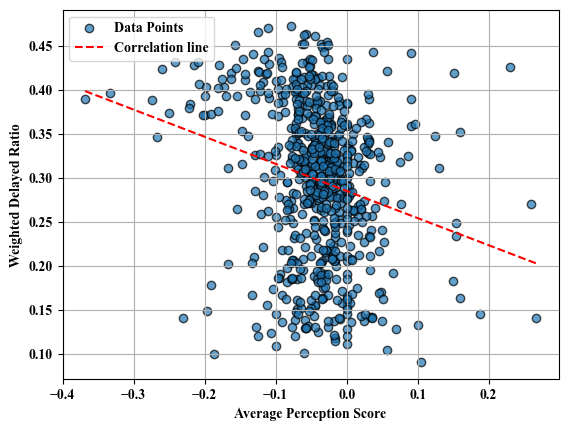

In [10]:
# Setting font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

# Scatter plot for average_sentiment vs weighted_delayed_ratio
plt.scatter(
    merged_df['average_sentiment'], 
    merged_df['weighted_delayed_ratio'], 
    alpha=0.7, edgecolors='k', label='Data Points'
)

# Adding a trendline
z = np.polyfit(merged_df['average_sentiment'], merged_df['weighted_delayed_ratio'], 1)
p = np.poly1d(z)
x_vals = np.linspace(merged_df['average_sentiment'].min(), merged_df['average_sentiment'].max(), 100)
plt.plot(
    x_vals, 
    p(x_vals), 
    color='red', linestyle='--', label='Correlation line'
)

# Adding titles and labels
plt.xlabel('Average Perception Score', fontweight='bold')
plt.ylabel('Weighted Delayed Ratio', fontweight='bold')

# Adding legend and grid
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calculate the recommended threshold
threshold = 4 / len(merged_df)  # Based on sample size
print(f"Cook's Distance threshold: {threshold}")

# Define function to remove high Cook's Distance points
def remove_high_cooks_distance(df, independent_vars, dependent_var, threshold):
    """
    Removes points with high Cook's Distance from a DataFrame.
    Parameters:
    - df: DataFrame containing the data.
    - independent_vars: List of independent variable column names.
    - dependent_var: Dependent variable column name.
    - threshold: Cook's Distance threshold (calculated externally).
    Returns:
    - Filtered DataFrame without high Cook's Distance points.
    """
    # Extract independent variables (X) and dependent variable (y)
    X = df[independent_vars]
    y = df[dependent_var]
    
    # Ensure all values are numeric and drop NaNs
    X = X.apply(pd.to_numeric, errors='coerce').dropna()
    y = pd.to_numeric(y, errors='coerce').dropna()
    
    # Align indices of X and y after cleaning
    X = X.loc[y.index]
    y = y.loc[X.index]

    # Add constant term for intercept
    X = sm.add_constant(X)

    # Fit OLS regression model
    model = sm.OLS(y, X).fit()

    # Calculate Cook's Distance
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]  # Extract Cook's Distance values

    # Add Cook's Distance to the DataFrame for filtering
    df = df.iloc[:len(cooks_d)].copy()  # Align DataFrame with calculated Cook's Distance values
    df.loc[:, 'cooks_d'] = cooks_d  # Safely add Cook's Distance column using .loc

    # Filter out points with Cook's Distance above the threshold
    filtered_df = df[df['cooks_d'] <= threshold].copy()

    # Drop Cook's Distance column before returning
    filtered_df.drop(columns=['cooks_d'], inplace=True)
    return filtered_df

# Define independent and dependent variables
independent_vars = ['average_sentiment', 'weighted_delayed_ratio']  # Independent variables
dependent_var = 'review_count'  # Replace with the actual dependent variable if applicable

# Remove high Cook's Distance points using the calculated threshold
filtered_df = remove_high_cooks_distance(merged_df, independent_vars, dependent_var, threshold)

# Check the resulting DataFrame
print(f"Original DataFrame size: {merged_df.shape[0]}")
print(f"Filtered DataFrame size: {filtered_df.shape[0]}")

# Display the filtered DataFrame
filtered_df

Cook's Distance threshold: 0.005813953488372093
Original DataFrame size: 688
Filtered DataFrame size: 658


,state,month,review_count,total_sentiment,average_sentiment,weighted_delayed_ratio
0,Alabama,2020-04,50,-10,-0.200000,0.372027
1,Alabama,2020-05,173,-19,-0.109827,0.391500
2,Alabama,2020-06,209,-26,-0.124402,0.421095
3,Alabama,2020-07,457,-35,-0.076586,0.322110
4,Alabama,2020-08,372,-8,-0.021505,0.319279
...,...,...,...,...,...,...
683,Wyoming,2020-12,39,0,0.000000,0.253589
684,Wyoming,2021-01,34,-4,-0.117647,0.221356
685,Wyoming,2021-02,22,-1,-0.045455,0.235709
686,Wyoming,2021-03,30,3,0.100000,0.133528


In [13]:
# Calculate the correlation between 'average_sentiment' and 'weighted_delayed_ratio'
correlation_value_1 = filtered_df['average_sentiment'].corr(filtered_df['weighted_delayed_ratio'])

# Display the correlation value
correlation_value_1

-0.25483573092010486

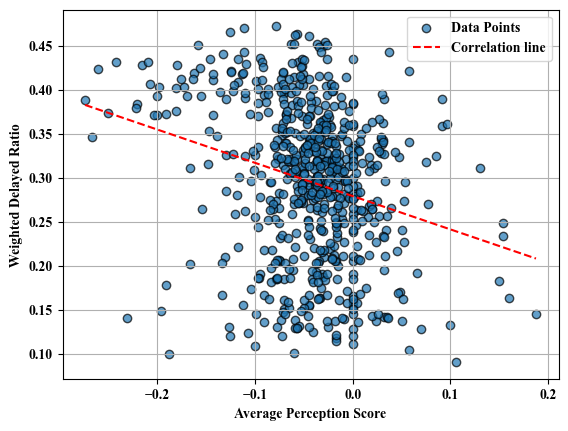

In [14]:
# Set font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

# Scatter plot for average_sentiment vs weighted_delayed_ratio
plt.scatter(
    filtered_df['average_sentiment'], 
    filtered_df['weighted_delayed_ratio'], 
    alpha=0.7, edgecolors='k', label='Data Points'
)

# Add a trendline
z = np.polyfit(filtered_df['average_sentiment'], filtered_df['weighted_delayed_ratio'], 1)
p = np.poly1d(z)
x_vals = np.linspace(filtered_df['average_sentiment'].min(), filtered_df['average_sentiment'].max(), 100)
plt.plot(
    x_vals, 
    p(x_vals), 
    color='red', linestyle='--', label='Correlation line'
)

# Add titles and labels
plt.xlabel('Average Perception Score', fontweight='bold')
plt.ylabel('Weighted Delayed Ratio', fontweight='bold')

# Add legend and grid
plt.legend()
plt.grid()
plt.show()